# OpenEQA QuickStart

Welcome! This notebook is intended to provide a quick-start guide to OpenEQA and its workflow. Before you can start using this notebook, please perform a few basic installation steps.

## Packages and Dependencies
- Install [openeqa](https://github.com/facebookresearch/open-eqa/blob/main/setup.py) and [required packages](https://github.com/facebookresearch/open-eqa/blob/main/requirements.txt).
- You don't need the full dataset to run this notebook and get started. But we highly encourage you to look at instructions to [download the data](https://github.com/facebookresearch/open-eqa/blob/main/data/README.md) and get started early! We realize getting access to the dataset has a few hoops to jump through and thus we provide this repo with a small "demo dataset" to give you a flavor of the benchmark.
- Get API access keys ready for different models (e.g. GPT, Claude) or host the model on your end (e.g. LLaMA, Mixtral).

## Data Visualization

Let's first start by visualizing a demo dataset generated from a [public HM3D scene](https://aihabitat.org/datasets/hm3d/).

In [1]:
import os
os.environ['OPENAI_API_KEY'] = '<YOUR_API_KEY>'
os.environ['OPENAI_AZURE_DEPLOYMENT'] = '1'

import matplotlib.pyplot as plt
from IPython.display import Video, Image

Video("/share/care-e/testing_videos/caree-1.mp4", embed=True, width=480)

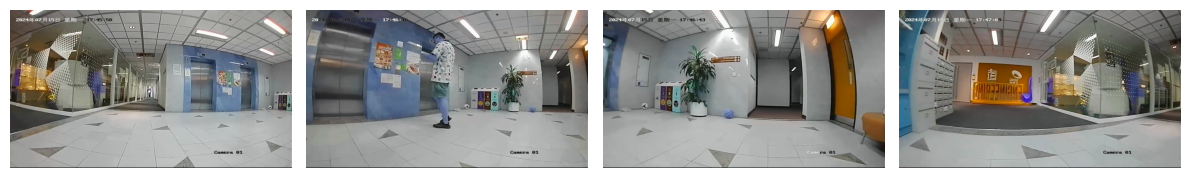

In [2]:
from PIL import Image
from tqdm import tqdm

from openeqa.utils.demo_utils import (
    decode_frames_from_video_path,
    get_equally_spaced_frames,
)

frames_per_traj = 15

# get the frames from the video
frames = decode_frames_from_video_path("/share/care-e/testing_videos/caree-1.mp4")

# extract equally spaced frames
frames = get_equally_spaced_frames(frames, frames_per_traj)

# display a few frames
_, axs = plt.subplots(1, 4, figsize=(12, 12))
for img, ax in zip(frames[::4], axs):
    ax.axis("off")
    ax.imshow(img)
plt.tight_layout()
plt.show()

## Load the Questions

In [4]:
import json

eqa_data = json.load(open("data/caree-eqa-v0.json"))
print(f'#EQA : {len(eqa_data)} instances')
print('\nTop-3 & Bottom-3 Samples:')
print(json.dumps(eqa_data[:3] + eqa_data[-3:], indent=2))

#EQA : 50 instances

Top-3 & Bottom-3 Samples:
[
  {
    "question": "What is the brown object next to the plant? ",
    "answer": "A basketball",
    "category": "object recognition",
    "question_id": "1-1",
    "episode_history": "caree-v0/caree-1"
  },
  {
    "question": "What is the object next to the keyboard?",
    "answer": "A globe",
    "category": "object recognition",
    "question_id": "1-2",
    "episode_history": "caree-v0/caree-1"
  },
  {
    "question": "What is the object that books and a clock are on?",
    "answer": "A sofa",
    "category": "object recognition",
    "question_id": "1-3",
    "episode_history": "caree-v0/caree-1"
  },
  {
    "question": "Is there recyling bin for metal?",
    "answer": "Yes",
    "category": "attribute recognition",
    "question_id": "2-22",
    "episode_history": "caree-v0/caree-2"
  },
  {
    "question": "What is the latest location of white ball?",
    "answer": "In front of the elevator",
    "category": "spatial understan

## Ask the Model

Let's start with a text-only (or blind) LLM. We'll use GPT-4 for illustration, but we encourage you to try out your own model!

First set the OPENAI_API_KEY environment variable to your own openai api key.

In [5]:
assert "OPENAI_API_KEY" in os.environ
if os.environ.get('OPENAI_AZURE_DEPLOYMENT') == '1':
    from openeqa.baselines.gpt4_azure import ask_question as ask_blind_gpt4
else:
    from openeqa.baselines.gpt4 import ask_question as ask_blind_gpt4

verbose = True

for item in tqdm(eqa_data[:3]):
    q = item["question"]
    a = item["answer"]
    blind_gpt4_a = ask_blind_gpt4(
        question=q,
        openai_model="gpt-4o",
    )
    item["blind_gpt4_answer"] = blind_gpt4_a
    if verbose:
        # print the question and the model's answer
        print("Q: {}\nA: {}\n".format(q, blind_gpt4_a))

 33%|████████████████████████████████████████████████████████▎                                                                                                                | 1/3 [00:01<00:02,  1.06s/it]

Q: What is the brown object next to the plant? 
A: a table



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2/3 [00:01<00:00,  1.02it/s]

Q: What is the object next to the keyboard?
A: A mouse



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

Q: What is the object that books and a clock are on?
A: A bookshelf



Next, lets try a multi-modal LLM. We'll use GPT-4V, but other models are implemented in the open-eqa codebase. 

In [8]:
assert "OPENAI_API_KEY" in os.environ
import glob

if os.environ.get('OPENAI_AZURE_DEPLOYMENT') == '1':
    from openeqa.baselines.gpt4o_azure import ask_question as ask_gpt4o
else:
    from openeqa.baselines.gpt4v import ask_question as ask_gpt4o

verbose = True

for item in tqdm(eqa_data[:3]):
    q = item["question"]
    image_paths = sorted(glob.glob(f"/share/open-eqa/frames/{item['episode_history']}/*.png"))

    num_filt_frames = 30
    sr = len(image_paths) // num_filt_frames
    filt_image_paths = []
    for rgb_img in image_paths[::sr]:
        filt_image_paths.append(rgb_img)
    
    gpt4o_a = ask_gpt4o(
        question=q,
        image_paths=filt_image_paths,
        openai_key=os.environ["OPENAI_API_KEY"],
        openai_model="gpt-4o",
    )
    item["gpt4o_answer"] = gpt4o_a
    if verbose:
        # print the question and the model's answer
        print("Q: {}\nA: {}\n".format(q, gpt4o_a))

 33%|████████████████████████████████████████████████████████▎                                                                                                                | 1/3 [00:11<00:23, 11.90s/it]

Q: What is the brown object next to the plant? 
A: The brown object next to the plant is a basketball.



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2/3 [00:19<00:09,  9.60s/it]

Q: What is the object next to the keyboard?
A: The object next to the keyboard is a globe.



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.88s/it]

Q: What is the object that books and a clock are on?
A: The books and a clock are on a series of blue and black benches.



## Evaluate the Answers w/ LLM-Match

Finally, we'll evaluate the open-vocabulary answers produced by an LLMs or multi-modal LLMs by comparing against the ground truth answer(s) using LLM-Match, which uses a rating of 1-5 to score answers. See the paper for more details.

In [10]:
assert "OPENAI_API_KEY" in os.environ
from openeqa.evaluation.llm_match import get_llm_match_score

# evaluate GPT-4 answers
for item in tqdm(eqa_data[:3]):
    c = get_llm_match_score(
        question=item["question"],
        answer=item["answer"],
        prediction=item["blind_gpt4_answer"],
    )  # correctness score (see Eq. 1 and Table 2 in paper)
    item["blind_gpt4_score"] = c

# evaluate GPT-4o answers
for item in tqdm(eqa_data[:3]):
    c = get_llm_match_score(
        question=item["question"],
        answer=item["answer"],
        prediction=item["gpt4o_answer"],
    )  # correctness score (see Eq. 1 and Table 2 in paper)
    item["gpt4o_score"] = c

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


In [11]:
# print the final results
print(json.dumps(eqa_data[:3], indent=2))

[
  {
    "question": "What is the brown object next to the plant? ",
    "answer": "A basketball",
    "category": "object recognition",
    "question_id": "1-1",
    "episode_history": "caree-v0/caree-1",
    "blind_gpt4_answer": "a table",
    "gpt4o_answer": "The brown object next to the plant is a basketball.",
    "blind_gpt4_score": 1,
    "gpt4o_score": 5
  },
  {
    "question": "What is the object next to the keyboard?",
    "answer": "A globe",
    "category": "object recognition",
    "question_id": "1-2",
    "episode_history": "caree-v0/caree-1",
    "blind_gpt4_answer": "A mouse",
    "gpt4o_answer": "The object next to the keyboard is a globe.",
    "blind_gpt4_score": 1,
    "gpt4o_score": 5
  },
  {
    "question": "What is the object that books and a clock are on?",
    "answer": "A sofa",
    "category": "object recognition",
    "question_id": "1-3",
    "episode_history": "caree-v0/caree-1",
    "blind_gpt4_answer": "A bookshelf",
    "gpt4o_answer": "The books an